## Random Forest Overview

Extending our learning from our decision tree model, we believe random forests would also work well for predicting pathogenicity because they can "discover" relationships between our data's features, such as their chromosome, position, and morphed nucleotide.

To avoid overfitting, our decision tree model used a relatively high `min_samples_leaf` value, potentially sacrificing accuracy and f1 score. In contrast, random forests naturally guard against overfitting by averaging the results of its predictors, which reduces variance without incresing bias. As a result, random forests could make for a beter model than decision trees.

### Preprocessing the Data

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

seed = 1234
np.random.seed(seed)

In [2]:
df = pd.read_csv('data/humsavar_dbnsfp53_complete.csv')

## preprocessing the data

# represent "ref" and "alt" cols in one "mutation" col
# map "mutation" col to numbers
df['mutation'] = df['ref'] + df['alt']
df = pd.get_dummies(df, columns=["mutation"], drop_first=False)

# encode chromosomes ('X' and 'Y')
chrom_mapping = {
    **{str(i): i for i in range(1, 23)},  # "1"–"22"
    "X": 23,
    "Y": 24
}
df["chr"] = df["chr"].map(chrom_mapping)

# encode labels
df['Label'] = df['Label'].map({'Pathogenic': 1, 'Benign': 0})

# encode SIFT, PolyPhen predictions
df = pd.get_dummies(df, columns=['SIFT_pred', 'Polyphen2_HDIV_pred'], drop_first=False)

# remove unnecessary columns
drop_cols = ['Gene', 'Entry', 'FTId', 'AA_change', 'Category',
             'dbSNP', 'Disease', 'rs_dbSNP', 'ref', 'alt']
df = df.drop(columns=drop_cols)


X = df.drop(columns=["Label"])
Y = df["Label"]

df.head()


,Label,chr,pos,SIFT_score,Polyphen2_HDIV_score,CADD_raw,CADD_phred,REVEL_score,mutation_AC,mutation_AG,...,mutation_GC,mutation_GT,mutation_TA,mutation_TC,mutation_TG,SIFT_pred_D,SIFT_pred_T,Polyphen2_HDIV_pred_B,Polyphen2_HDIV_pred_D,Polyphen2_HDIV_pred_P
0,1,1,93998027,0.049,0.765,4.435338,25.30,0.860,False,True,...,False,False,False,False,False,True,False,False,False,True
1,0,1,93998061,0.053,0.975,2.412747,18.61,0.503,False,False,...,False,False,False,False,False,False,True,False,True,False
2,0,1,93998061,0.268,0.061,1.492491,14.14,0.313,False,False,...,False,False,False,False,False,False,True,True,False,False
3,1,1,94000836,1.000,0.051,2.740497,20.10,0.577,False,False,...,False,False,False,True,False,False,True,True,False,False
4,1,1,94000866,0.000,1.000,4.731917,26.50,0.937,False,False,...,False,False,False,False,False,True,False,False,True,False


In [4]:
Xtr, Xte, Ytr, Yte = train_test_split(
    X, Y, test_size=0.15,
    random_state=seed,
)

## Default Random Forest

In [7]:
RF = RandomForestClassifier(random_state=seed)
RF.fit(Xtr, Ytr)

ytr_pred = RF.predict(Xtr)
yte_pred = RF.predict(Xte)

print("Train Accuracy:", accuracy_score(Ytr, ytr_pred))
print("Train F1 Score:", f1_score(Ytr, ytr_pred, average="macro"))
print()
print("Test Accuracy:", accuracy_score(Yte, yte_pred))
print("Test F1 Score:", f1_score(Yte, yte_pred, average="macro"))


Train Accuracy: 0.9991396924400473
Train F1 Score: 0.9989989265831768

Test Accuracy: 0.9293113954905545
Test F1 Score: 0.9175848154754689


scikitlearn's default RandomForestClassifier starts us off with pretty good test accuracy and F1 scores, better than the default DecisionTreeClassifier.

## Training with GridSearchCV

Instead of varying each hyperparameter manually like we did in `decision_tree.ipynb`, we will use `GridSearchCV` to test many combinations of hyperparameters and select the best one. This approach also uses cross-validation to avoid overfitting.

In [13]:
param_options = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": list(range(1, 20)) + [40, 50, 100],
    "min_samples_leaf": [1, 5, 10, 20, 30],
    "max_features": ["sqrt", 0.5],
    "n_estimators": [1, 5, 10, 25, 50, 100, 200, 400]
}

grid = GridSearchCV(
    RF,
    param_grid=param_options,
    scoring="f1",
    cv=5,
    n_jobs=-1
)
grid.fit(Xtr, Ytr)

,estimator,RandomForestC...om_state=1234)
,param_grid,"{'criterion': ['gini', 'entropy', ...], 'max_depth': [1, 2, ...], 'max_features': ['sqrt', 0.5], 'min_samples_leaf': [1, 5, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [14]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values(by="mean_test_score", ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1245,1.550403,0.020890,0.017581,0.003695,gini,16,0.5,1,100,"{'criterion': 'gini', 'max_depth': 16, 'max_fe...",0.894828,0.877922,0.907216,0.903614,0.895600,0.895836,0.010119,1
1165,1.454377,0.026443,0.016873,0.002166,gini,15,0.5,1,100,"{'criterion': 'gini', 'max_depth': 15, 'max_fe...",0.891003,0.883921,0.909091,0.893691,0.898276,0.895196,0.008361,2
1166,2.876310,0.048262,0.032955,0.001778,gini,15,0.5,1,200,"{'criterion': 'gini', 'max_depth': 15, 'max_fe...",0.893103,0.876830,0.908469,0.896373,0.898100,0.894575,0.010254,3
3005,1.481707,0.047628,0.018612,0.003438,entropy,16,0.5,1,100,"{'criterion': 'entropy', 'max_depth': 16, 'max...",0.895238,0.879310,0.906438,0.895600,0.895780,0.894473,0.008679,4
4765,1.562583,0.062047,0.017904,0.003346,log_loss,16,0.5,1,100,"{'criterion': 'log_loss', 'max_depth': 16, 'ma...",0.895238,0.879310,0.906438,0.895600,0.895780,0.894473,0.008679,4


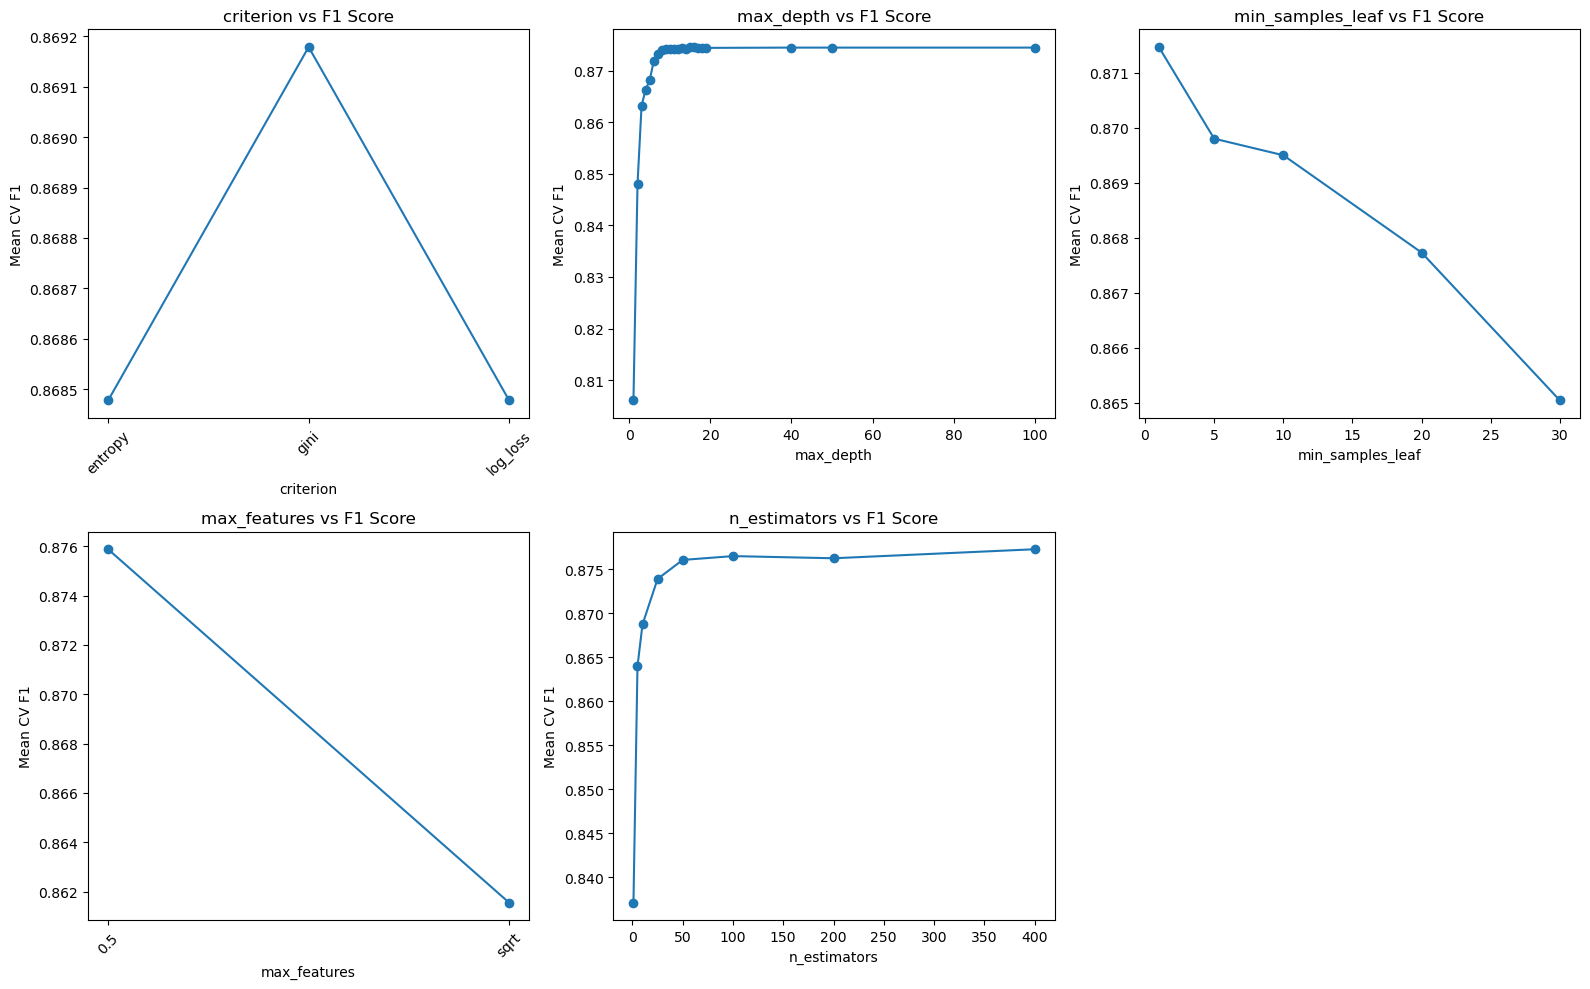

In [19]:
params = list(param_options.keys())

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, param in enumerate(params):
    ax = axes[i]
    col = f"param_{param}"

    grouped_scores = results.groupby(col)["mean_test_score"].mean()

    # determine if param args are numeric or categorical
    numeric = pd.api.types.is_numeric_dtype(grouped_scores.index)

    if numeric:
        grouped_scores = grouped_scores.sort_index()
        ax.plot(grouped_scores.index, grouped_scores.values, marker="o")
    else:
        # convert index to string for plotting
        x_vals = grouped_scores.index.astype(str)
        ax.plot(range(len(x_vals)), grouped_scores.values, marker="o")
        ax.set_xticks(range(len(x_vals)))
        ax.set_xticklabels(x_vals, rotation=45)

    ax.set_title(f"{param} vs F1 Score")
    ax.set_xlabel(param)
    ax.set_ylabel("Mean CV F1")

# hide 6th plot
for j in range(len(params), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

After plotting each feature's effect on the model's F1 score, we can see that `n_estimators` had the biggest impact (<0.84 at 0 to >0.875 at 400 estimators). 

## Conclusion

In [22]:
RF_best = grid.best_estimator_
print("Best Model Parameters:", grid.best_params_)

ytr_pred = RF_best.predict(Xtr)
yte_pred = RF_best.predict(Xte)

print("Train Accuracy:", accuracy_score(Ytr, ytr_pred))
print("Train F1 Score:", f1_score(Ytr, ytr_pred, average="macro"))
print()
print("Test Accuracy:", accuracy_score(Yte, yte_pred))
print("Test F1 Score:", f1_score(Yte, yte_pred, average="macro"))

Best Model Parameters: {'criterion': 'gini', 'max_depth': 16, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 100}
Train Accuracy: 0.998709538660071
Train F1 Score: 0.9984986715850954

Test Accuracy: 0.9293113954905545
Test F1 Score: 0.9176729268157662


After 37 minutes of runtime, `GridSearchCV` yielded a model that is sadly only marginally better than the default random forest classifier. From this we can assume that the default was already a relatively strong model. Our final model also still seems to overfit the data.

Since tuning parameters does not seem to have a large impact on our model's accuracy, we may need to reevaluate the *quality* of our data. Our learning would benefit from more data and more features that have strong predicitive power.